# Modifying the original dataset

### Loading the dataset and starting up Spark

In [13]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import length, split, size

#SparkContext.setSystemProperty('spark.executor.memory', '1g')
#SparkContext.setSystemProperty('spark.driver.memory', '8g')
#SparkContext.setSystemProperty('spark.cores.max', '12')

#sc = SparkContext("local", "Project_BDT")

spark = SparkSession.builder.appName('Project_BDT').getOrCreate()

base_df = spark.read.option("escape", "\"").csv("E:/Dataset/all_reviews.csv", header=True)

base_df.show()

# --deploy-mode cluster --driver-memory 4g --executor-memory 4g

+----------------+-----+--------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+---------+----------------------------------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+---------------------+--------------------+
|recommendationid|appid|          game|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played| language|                            review|timestamp_created|timestamp_updated|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|hidden_in_steam_china|steam_china_location|
+----------------+-----+--------------+-----------------+----------------------+------------------+---

### Drop Chinese reviews
I promise this has its reason, will explain later

In [16]:
df = base_df.filter(base_df["language"] != "schinese")

### Drop useless columns/columns that can identify users

In [17]:
df = df.drop("recommendationid", # uniquely identifies the review
                    "appid", # uniquely identifies the game
                    "game", # game's name
                    "author_steamid" # uniquely identifies the user
                    )

### Add new columns related to the reviews
Since we're not going to use NLP, we're not going to make use of the review column. Still, we can take some data from it:
- in review_chars we save the amount of characters in the review
- in review_words we save the amount of words in the review

In [18]:
df = df.withColumn("review_chars", length(df["review"]))
df = df.withColumn("review_words", size(split(df["review"], " ")))

### Drop the review column

In [19]:
df = df.drop("review")

### Filter out reviews based on number of words
For reviews scored above 0.8, the average is around 134, with a standard deviation of around 258.
I initially planned to take the average and subtract the standard deviation from it, but clearly that is not possible.
Since I didn't want to filter out too many reviews, I picked a very low number, such as 2.
This is also the reason why the simplified Chinese reviews were filtered out - they'd be taken as one huge word.
There might be other languages for which this was the case. I did initially want to find this out, but sadly due to some encoding problems Spark would keep failing after half an hour or so. I tried this several times, but got tired of it and just decided to take this route.

In [20]:
df = df.filter(df["review_words"] >= 2)

# count_lower_than_2 = 12,964,318 - this is the amount of reviews with less than 2 words

### Drop the language column
Since English makes up for 45% of the dataset (according to Kaggle), there would clearly be some sort of bias towards those reviews, be it good or bad.
Besides, the language shouldn't matter in deciding whether a review is helpful or not.

In [21]:
df = df.drop("language")

### Drop timestamp_created and timestamp_updated column and replace them with a single column
Ultimately we only care if a review was updated or not, not when it was created and when was its latest update at the time of this dataset's creation

In [22]:
df = df.withColumn("updated", df["timestamp_created"] != df["timestamp_updated"])

df = df.drop("timestamp_created", "timestamp_updated")

### Save everything
Since operations on the initial dataset would take upwards of 30 minutes, it's about time we save everything to a new dataset.

In [24]:
df.repartition(1).write.option("header", True).csv("E:/Dataset/new_dataset")

### Look at one example of a review for each language (NOT USED)
Sadly this wasn't used since it would always complain about the encoding 30-something minutes in. After several attempts I figured I have better things to do with my life and moved on.

In [4]:
review_examples = df.dropDuplicates(["language"])

review_examples.select("language", "review").show(300, False)

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "c:\Users\Sonic\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Sonic\AppData\Local\Temp\ipykernel_19636\2682796960.py", line 3, in <module>
    review_examples.select("language", "review").show(300, False)
  File "c:\Users\Sonic\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\dataframe.py", line 945, in show
    print(self._show_string(n, truncate, vertical))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Sonic\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\dataframe.py", line 976, in _show_string
    return self._jdf.showString(n, int_truncate, vertical)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Sonic\AppData\Local\Programs\Python\Python311\Lib\site-packages\py4j\j

ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

# New dataset stuff

### Imports

In [3]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import length, split, size, col
from pyspark.sql.types import IntegerType, FloatType

### Loading the dataset and creating the pyspark session

In [4]:
spark = SparkSession.builder.appName('Project_BDT').getOrCreate()

df = spark.read.option("escape", "\"").csv("E:/Dataset/new_dataset.csv", header=True)

df.show()

+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+--------+--------+-------------------+-------------+--------------+-----------------+---------------------------+---------------------+------------+------------+-------+
|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|voted_up|votes_up|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|hidden_in_steam_china|review_chars|review_words|updated|
+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+--------+--------+-------------------+-------------+--------------+-----------------+---------------------------+---------------------+------------+------------+-------+
|                     0|                21|                  

### Dropping some more unnecessary columns

In [20]:
df = df.drop("steam_china_location", # Kaggle mentions this column has 100% NULL values.
                "votes_funny") # correlation matrix shows that this values does not affect ANY other value in any way whatsoever

### Saving new dataset

In [21]:
df.repartition(1).write.option("header", True).csv("E:/Dataset/new_dataset")

### Check schema

In [3]:
df.printSchema()

root
 |-- author_num_games_owned: string (nullable = true)
 |-- author_num_reviews: string (nullable = true)
 |-- author_playtime_forever: string (nullable = true)
 |-- author_playtime_last_two_weeks: string (nullable = true)
 |-- author_playtime_at_review: string (nullable = true)
 |-- author_last_played: string (nullable = true)
 |-- voted_up: string (nullable = true)
 |-- votes_up: string (nullable = true)
 |-- votes_funny: string (nullable = true)
 |-- weighted_vote_score: string (nullable = true)
 |-- comment_count: string (nullable = true)
 |-- steam_purchase: string (nullable = true)
 |-- received_for_free: string (nullable = true)
 |-- written_during_early_access: string (nullable = true)
 |-- hidden_in_steam_china: string (nullable = true)
 |-- steam_china_location: string (nullable = true)
 |-- review_chars: string (nullable = true)
 |-- review_words: string (nullable = true)
 |-- updated: string (nullable = true)



### Count NaN values

In [9]:
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+---------------------+------------+------------+-------+
|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|hidden_in_steam_china|review_chars|review_words|updated|
+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+---------------------+------------+------------+-------+
|                     0| 

### Count null values

In [15]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+---------------------+------------+------------+-------+
|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|hidden_in_steam_china|review_chars|review_words|updated|
+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+---------------------+------------+------------+-------+
|                     0| 

### Remove null values 
It's just easier this way, 500-something rows deleted in a dataset of over 1 million rows won't do anything in the end


In [14]:
df = df.na.drop()

### Modify each column to be treated as numeric

In [5]:
int_columns = df.columns
int_columns.remove("weighted_vote_score")

for column in df.columns:
    df = df.withColumn(column, col(column).cast(IntegerType()))
    
df = df.withColumn("weighted_vote_score", col("weighted_vote_score").cast(FloatType()))

['author_num_games_owned', 'author_num_reviews', 'author_playtime_forever', 'author_playtime_last_two_weeks', 'author_playtime_at_review', 'author_last_played', 'voted_up', 'votes_up', 'comment_count', 'steam_purchase', 'received_for_free', 'written_during_early_access', 'hidden_in_steam_china', 'review_chars', 'review_words', 'updated']


### Correlation Matrix (doesn't work on latest Python version)

ValueError: Must pass 2-d input. shape=()

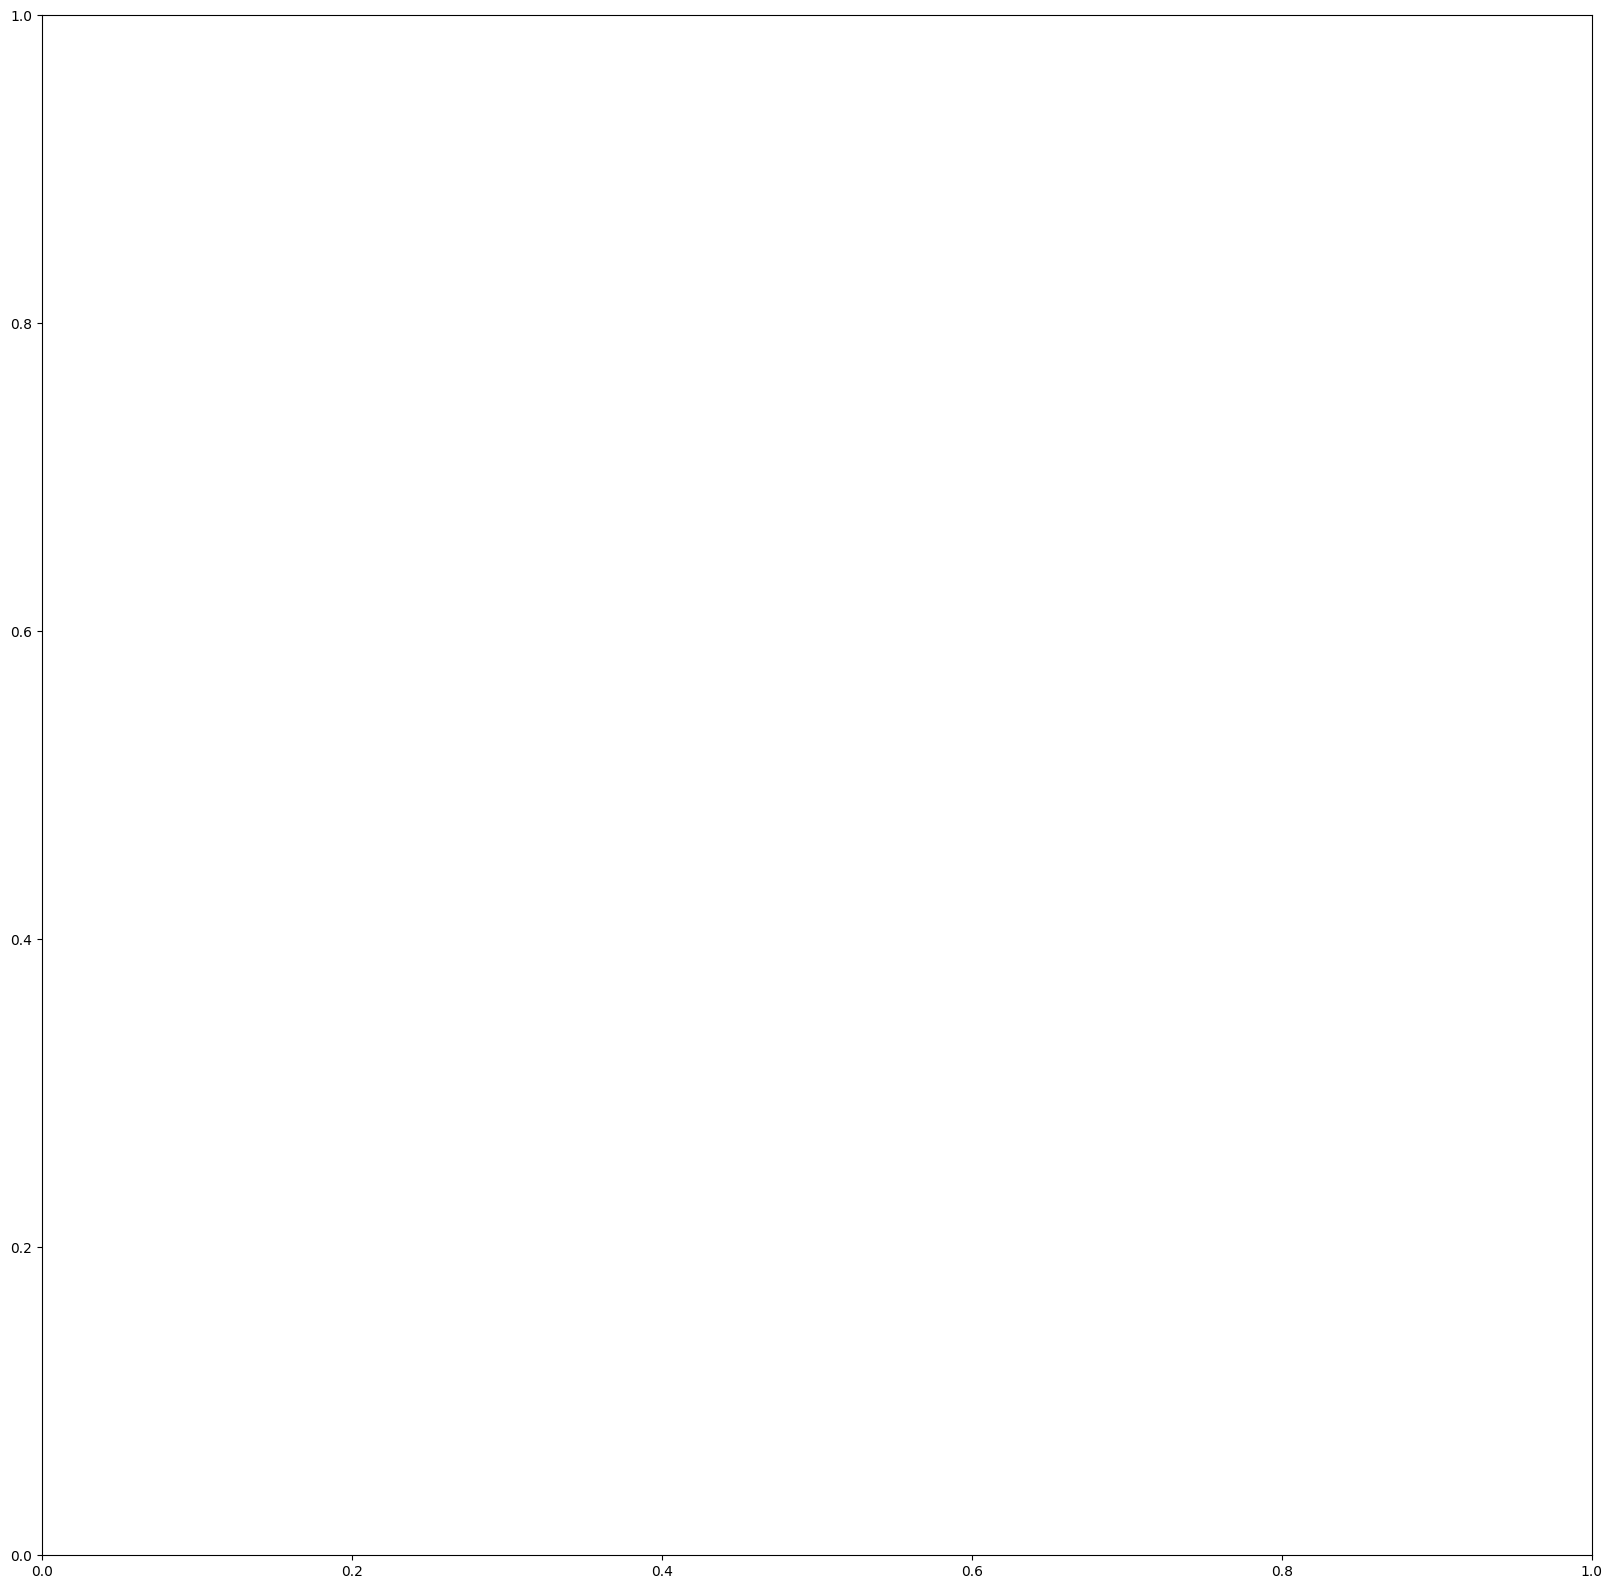

In [10]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df.columns, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

# get correlation matrix
corr = Correlation.corr(df_vector, vector_col) # Apparently this throws an error because I'm using the latest Python version
# Hooray for updates

matrix = corr.collect()[0][0] 
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = df.columns, index=df.columns) 
corr_matrix_df.style.background_gradient(cmap='coolwarm').set_precision(2)


,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,voted_up,votes_up,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,hidden_in_steam_china,review_chars,review_words,updated
author_num_games_owned,1.00,0.34,-0.04,-0.02,-0.03,-0.06,-0.03,0.03,0.13,0.04,-0.05,0.01,-0.02,-0.04,0.01,0.02,0.07
author_num_reviews,0.34,1.00,-0.03,-0.01,-0.03,-0.05,-0.04,0.01,0.06,0.01,-0.04,0.02,-0.01,-0.00,0.01,0.01,0.04
author_playtime_forever,-0.04,-0.03,1.00,0.35,0.78,0.10,0.02,0.00,0.03,0.02,-0.03,0.01,-0.04,-0.06,-0.00,-0.00,0.08
author_playtime_last_two_weeks,-0.02,-0.01,0.35,1.00,0.22,0.06,0.01,-0.00,-0.01,0.00,-0.01,0.01,-0.01,0.09,-0.00,-0.00,0.02
author_playtime_at_review,-0.03,-0.03,0.78,0.22,1.00,0.08,-0.01,0.00,0.01,0.02,-0.03,-0.00,-0.05,-0.01,-0.00,-0.00,0.07
author_last_played,-0.06,-0.05,0.10,0.06,0.08,1.00,0.08,-0.03,-0.11,-0.02,0.00,0.02,0.05,0.12,-0.00,-0.01,0.01
voted_up,-0.03,-0.04,0.02,0.01,-0.01,0.08,1.00,-0.04,-0.21,-0.06,0.05,0.01,-0.01,-0.02,-0.01,-0.02,-0.10
votes_up,0.03,0.01,0.00,-0.00,0.00,-0.03,-0.04,1.00,0.14,0.42,0.00,-0.00,0.00,-0.00,0.01,0.02,0.03
weighted_vote_score,0.13,0.06,0.03,-0.01,0.01,-0.11,-0.21,0.14,1.00,0.10,-0.01,-0.00,0.02,-0.08,0.02,0.04,0.13
comment_count,0.04,0.01,0.02,0.00,0.02,-0.02,-0.06,0.42,0.10,1.00,-0.00,0.00,0.01,-0.02,0.01,0.02,0.06


### Drop completely useless columns

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('Project_BDT').getOrCreate()

df = spark.read.option("escape", "\"").csv("E:/Dataset/new_dataset1.csv", header=True)

df = df.drop("author_playtime_last_two_weeks", 
            "author_playtime_at_review", 
            "steam_purchase", 
            "received_for_free", 
            "written_during_early_access", 
            "review_chars", 
            "review_words", 
            "author_playtime_forever")

df = df.na.drop()

df.repartition(1).write.option("header", True).csv("E:/Dataset/new_dataset")

### Correlation Matrix

                                author_num_games_owned  author_num_reviews  \
author_num_games_owned                        1.000000            0.312809   
author_num_reviews                            0.312809            1.000000   
author_playtime_forever                      -0.024405           -0.025913   
author_playtime_last_two_weeks               -0.019213           -0.014198   
author_playtime_at_review                    -0.019567           -0.022168   
author_last_played                           -0.046128           -0.036002   
voted_up                                     -0.022906           -0.028681   
votes_up                                      0.030098            0.009602   
weighted_vote_score                           0.124176            0.056537   
comment_count                                -0.000051           -0.000024   
steam_purchase                               -0.030944           -0.040892   
received_for_free                             0.012017          

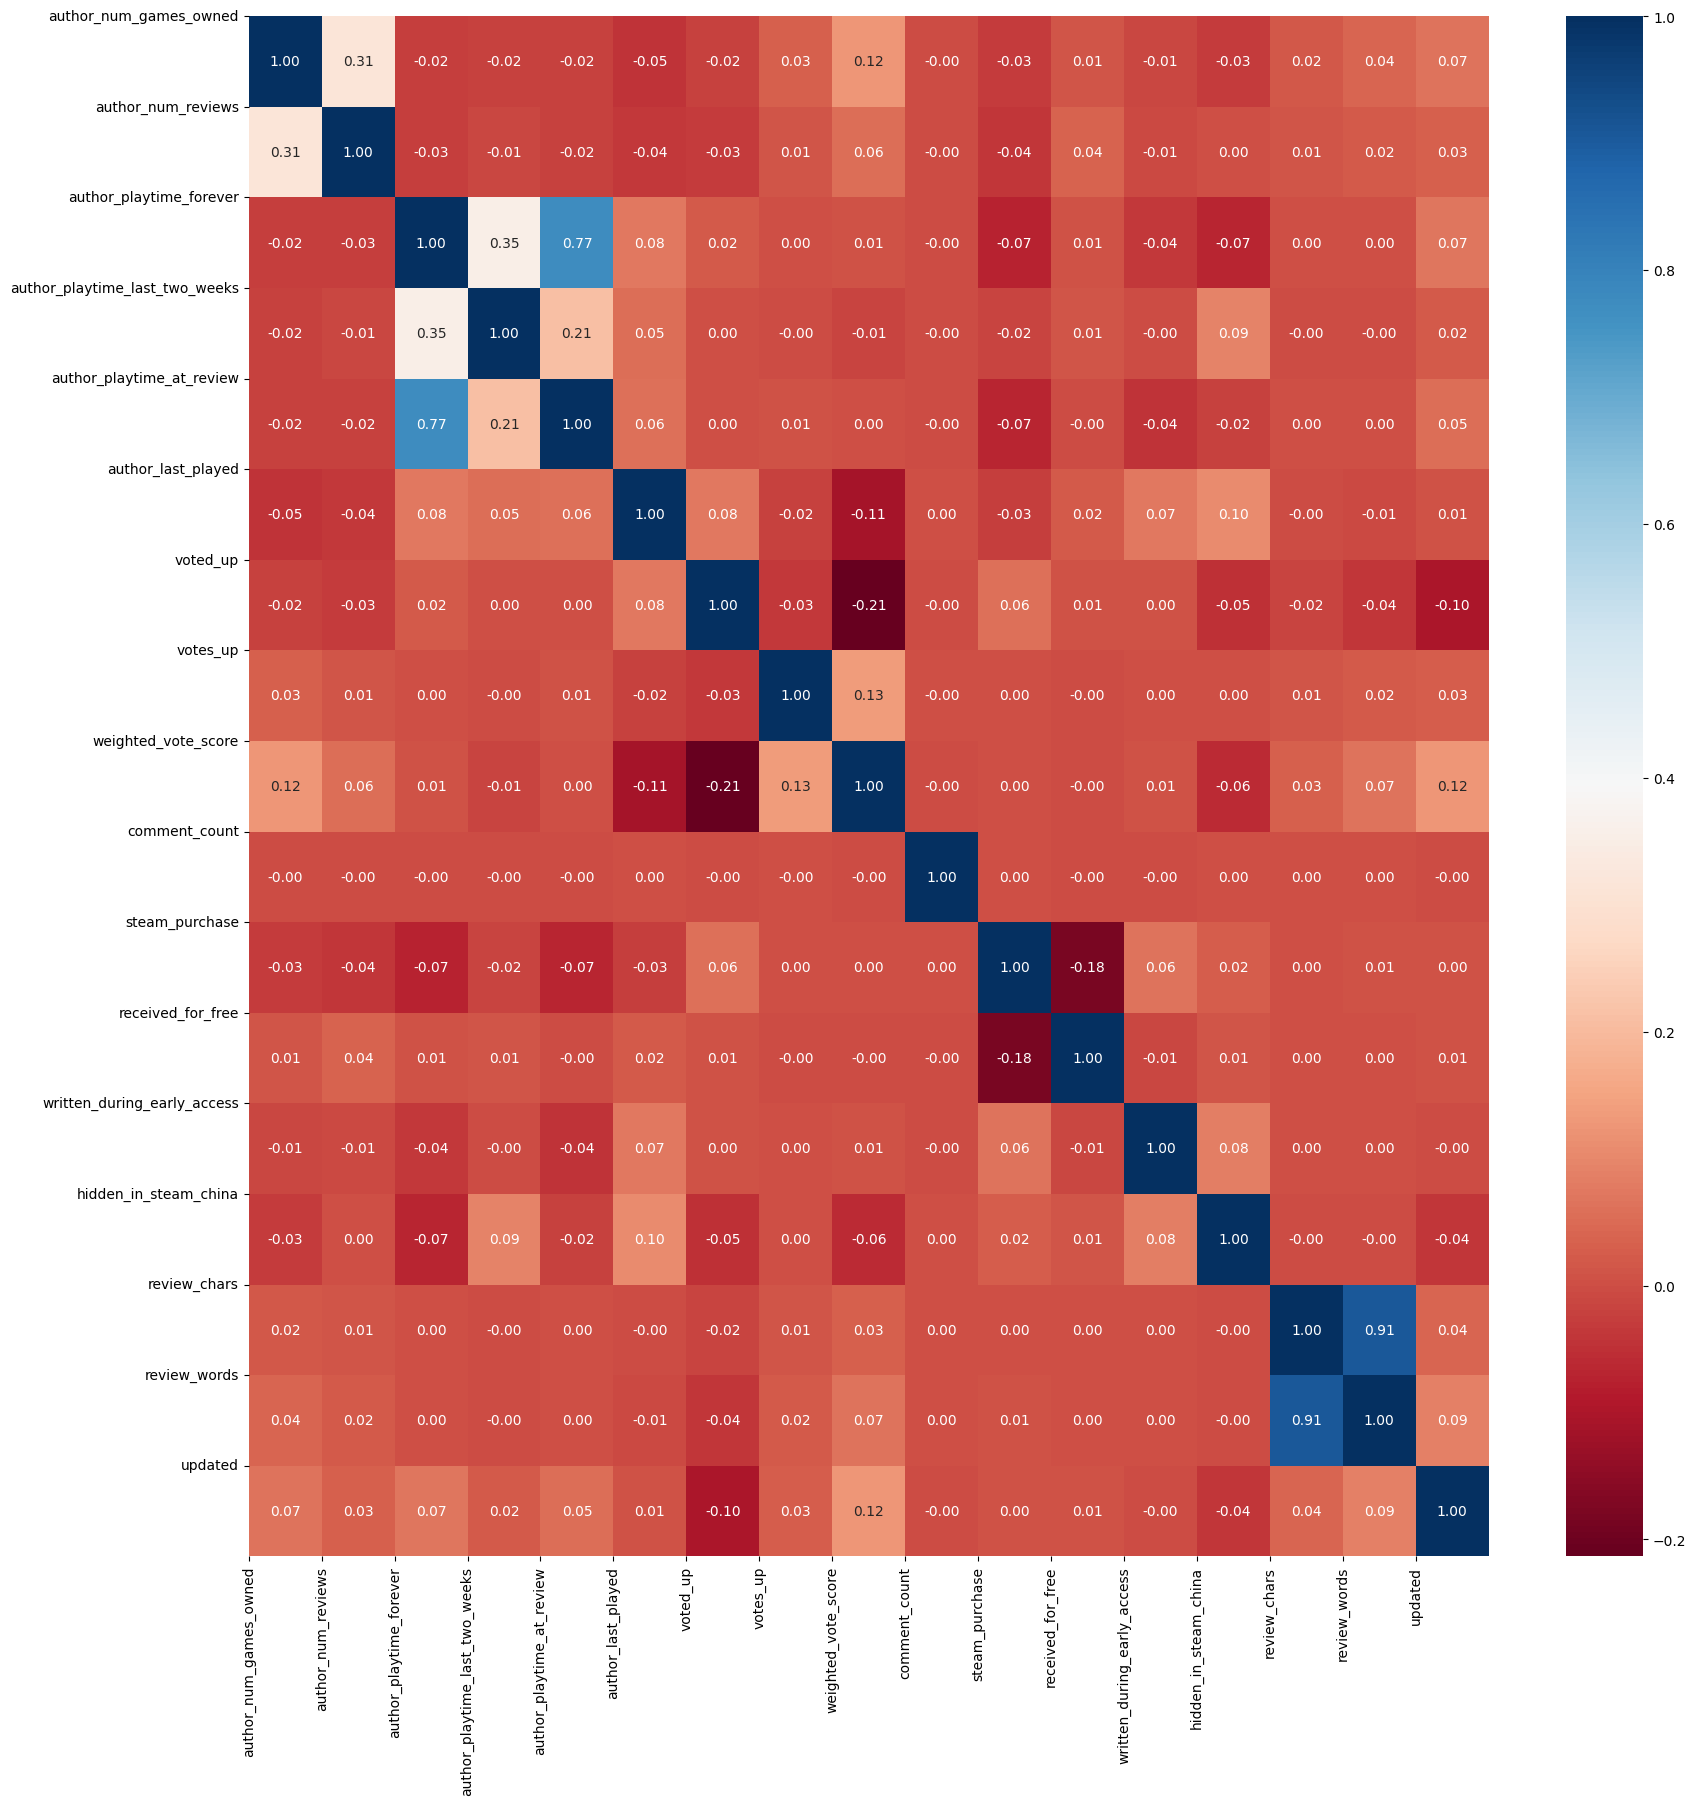

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# is this stupid? Yes. 
# Is it the only way to get a correlation matrix without downgrading my Python version 
# and possibly causing more problems for myself? Also yes.

pandas_df = pd.read_csv("E:/Dataset/new_dataset.csv", delimiter=',', chunksize = 30_000_000)

# i = 0

# if i == 3055: # there's some issue in this one, I don't get what it is, but oh well. One chunk won't be the end of it all.
#     continue

chunk = pandas_df.get_chunk()

chunk["updated"] = chunk["updated"].astype(int)
corr_matrix = chunk.corr(method = "pearson")

print(corr_matrix)
fig, ax = plt.subplots ( figsize =(20, 20) )
sns.heatmap ( corr_matrix , cmap = "RdBu" , annot = True , fmt = ".2f")
plt.xticks ( range ( len ( corr_matrix.columns ) ) , corr_matrix.columns )
plt.yticks ( range ( len ( corr_matrix.columns ) ) , corr_matrix.columns )
plt.show ()


# Machine Learning Stuff

### Imports

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, BooleanType, FloatType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor, \
                                    GBTRegressionModel, RandomForestRegressionModel, LinearRegressionModel
from pyspark.mllib.evaluation import MulticlassMetrics

import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import os
import sys
import findspark

### Formatting data for MLLib and opening dataset

In [2]:
columns_with_types = [
                        ('author_num_games_owned', IntegerType()),
                        ('author_num_reviews', IntegerType()),
                        ('author_last_played', IntegerType()),
                        ('voted_up', IntegerType()),
                        ('votes_up', IntegerType()),
                        ("weighted_vote_score", DoubleType()),
                        ('comment_count', IntegerType()),
                        ('hidden_in_steam_china', IntegerType()),
                        ('updated', BooleanType())
                    ]

columns = []

for column in columns_with_types:
    columns.append(StructField(column[0], column[1], False))

schema = StructType(fields=columns)

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

findspark.init()

spark = SparkSession.builder.appName('Project_BDT').getOrCreate()

df = spark.read.option("escape", "\"").csv("E:/Dataset/new_dataset.csv", header=True, schema=schema)
# print(df.count()) # 83_329_702

df = df.na.drop()

df = df.limit(80_000_000)
# print(df.count()) # 83_329_700 (despite dropping all na values LIKE FOUR TIMES BEFORE THIS, 
# apparently there are still 2 such values??? Riot's code makes more sense than this.)
# df.show()

### Assemble features into vector

In [3]:
input_cols = df.columns
input_cols.remove("weighted_vote_score")

In [4]:
assembler = VectorAssembler(inputCols=input_cols, outputCol='features')
output = assembler.transform(df)

final_data = output.select(["features", "weighted_vote_score"])

### Split data

In [5]:
train_data, test_data = final_data.randomSplit([0.7, 0.3], seed = 42)

### Look at data summary

In [16]:
train_data.describe().show()
test_data.describe().show()
"""
+-------+-------------------+ +-------+-------------------+
|summary|weighted_vote_score| |summary|weighted_vote_score|
+-------+-------------------+ +-------+-------------------+
|  count|           58329038| |  count|           55998941|
|   mean|0.19324147237605158| |   mean|0.19369684608294668|
| stddev|0.25465477029018263| | stddev|0.25472377106809463|
|    min|                0.0| |    min|                0.0|
|    max|  0.992186486721039| |    max|   0.99554705619812|
+-------+-------------------+ +-------+-------------------+

+-------+-------------------+ +-------+-------------------+
|summary|weighted_vote_score| |summary|weighted_vote_score|
+-------+-------------------+ +-------+-------------------+
|  count|           25000662| |  count|           24001059|
|   mean|0.19328120075477784| |   mean|0.19369606716058654|
| stddev| 0.2546592866964066| | stddev| 0.2547157660242294|
|    min|                0.0| |    min|                0.0|
|    max|   0.99554705619812| |    max|   0.99172168970108|
+-------+-------------------+ +-------+-------------------+
"""

+-------+-------------------+
|summary|weighted_vote_score|
+-------+-------------------+
|  count|           55998941|
|   mean|0.19369684608294668|
| stddev|0.25472377106809463|
|    min|                0.0|
|    max|   0.99554705619812|
+-------+-------------------+

+-------+-------------------+
|summary|weighted_vote_score|
+-------+-------------------+
|  count|           24001059|
|   mean|0.19369606716058654|
| stddev| 0.2547157660242294|
|    min|                0.0|
|    max|   0.99172168970108|
+-------+-------------------+



'\n+-------+-------------------+\n|summary|weighted_vote_score|\n+-------+-------------------+\n|  count|           58329038|\n|   mean|0.19324147237605158|\n| stddev|0.25465477029018263|\n|    min|                0.0|\n|    max|  0.992186486721039|\n+-------+-------------------+\n\n+-------+-------------------+\n|summary|weighted_vote_score|\n+-------+-------------------+\n|  count|           25000662|\n|   mean|0.19328120075477784|\n| stddev| 0.2546592866964066|\n|    min|                0.0|\n|    max|   0.99554705619812|\n+-------+-------------------+\n'

### Linear Regression

In [14]:
lr = LinearRegression(labelCol='weighted_vote_score')

In [17]:
lr_model = lr.fit(train_data)

In [6]:
lr_model = LinearRegressionModel.load("E:/Dataset/LR_Model/")

In [12]:
test_results.rootMeanSquaredError
# 0.24183558731131313 with all features

0.24183558731131313

In [13]:
test_results.r2
# 0.09817680657876204 with all features

0.09817680657876204

In [7]:
predictions = lr_model.transform(test_data)

In [ ]:
predictions.show()
"""
+--------------------+-------------------+-------------------+
|            features|weighted_vote_score|         prediction|
+--------------------+-------------------+-------------------+
|(16,[0,1,2,3,4,5,...|                0.0|0.16079451935547778|
|(16,[0,1,2,3,4,5,...|  0.476190477609634|0.15153386956147002|
|(16,[0,1,2,3,4,5,...|                0.0| 0.1468248391700827|
|(16,[0,1,2,3,4,5,...|                0.0| 0.1401885887428474|
|(16,[0,1,2,3,4,5,...|  0.479658782482147|0.14894618486044953|
|(16,[0,1,2,3,4,5,...|                0.0|0.15051482418844253|
|(16,[0,1,2,3,4,5,...|                0.0|0.15323843080362148|
|(16,[0,1,2,3,4,5,...|                0.0| 0.1553304913772932|
|(16,[0,1,2,3,4,5,...|                0.0|0.16886562145767536|
|(16,[0,1,2,3,4,5,...|                0.0| 0.1464463940026613|
|(16,[0,1,2,3,4,5,...|                0.0|0.14666772849685356|
|(16,[0,1,2,3,4,5,...|                0.0|0.14682167392822282|
|(16,[0,1,2,3,4,5,...|                0.0|0.17431660812878386|
|(16,[0,1,2,3,4,5,...|                0.0| 0.1742172430226242|
|(16,[0,1,2,3,4,5,...|                0.0|0.13684842057530433|
|(16,[0,1,2,3,4,5,...|                0.0|0.20788256384324244|
|(16,[0,1,2,3,4,5,...|                0.0|0.20796672754817197|
|(16,[0,1,2,3,4,5,...|                0.0|0.19018412219059716|
|(16,[0,1,2,3,4,5,...|                0.0| 0.1484926814880183|
|(16,[0,1,2,3,4,5,...|                0.0|0.14238436530489945|
+--------------------+-------------------+-------------------+ with all features
"""

+--------------------+-------------------+-------------------+
|            features|weighted_vote_score|         prediction|
+--------------------+-------------------+-------------------+
|(16,[0,1,2,3,4,5,...|                0.0|0.16079451935547778|
|(16,[0,1,2,3,4,5,...|  0.476190477609634|0.15153386956147002|
|(16,[0,1,2,3,4,5,...|                0.0| 0.1468248391700827|
|(16,[0,1,2,3,4,5,...|                0.0| 0.1401885887428474|
|(16,[0,1,2,3,4,5,...|  0.479658782482147|0.14894618486044953|
|(16,[0,1,2,3,4,5,...|                0.0|0.15051482418844253|
|(16,[0,1,2,3,4,5,...|                0.0|0.15323843080362148|
|(16,[0,1,2,3,4,5,...|                0.0| 0.1553304913772932|
|(16,[0,1,2,3,4,5,...|                0.0|0.16886562145767536|
|(16,[0,1,2,3,4,5,...|                0.0| 0.1464463940026613|
|(16,[0,1,2,3,4,5,...|                0.0|0.14666772849685356|
|(16,[0,1,2,3,4,5,...|                0.0|0.14682167392822282|
|(16,[0,1,2,3,4,5,...|                0.0|0.17431660812

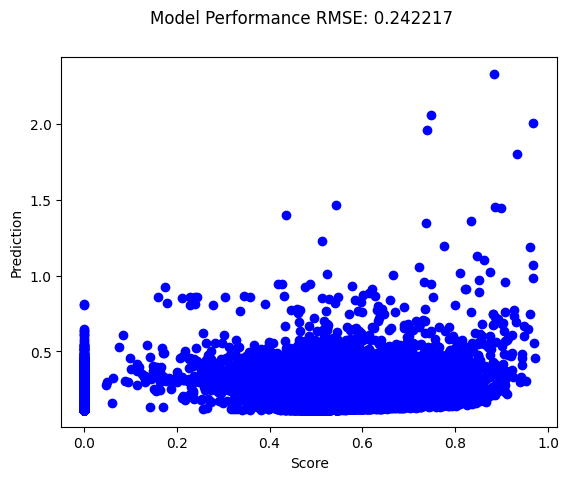

In [21]:
evaluator = RegressionEvaluator(labelCol="weighted_vote_score", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions)

lrPred = lr_model.transform(final_data)
lrResult = lrPred.sample(withReplacement=False, fraction=0.001, seed=None).toPandas()

plt.plot(lrResult.weighted_vote_score, lrResult.prediction, 'bo')
plt.xlabel('Score')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

[('voted_up', 0.13162024626626434), ('hidden_in_steam_china', 0.07000554737248041), ('comment_count', 0.04391876326498363), ('weighted_vote_score', 0.004275673816459887), ('votes_up', 0.0007896288826287803), ('author_num_games_owned', 4.993452946637005e-05), ('author_num_reviews', 1.2943882328329792e-05), ('author_last_played', 9.13597375071254e-11)]
[0.13162024626626434, 0.07000554737248041, 0.04391876326498363, 0.004275673816459887, 0.0007896288826287803, 4.993452946637005e-05, 1.2943882328329792e-05, 9.13597375071254e-11]


Text(0.5, 1.0, 'Feature Importances')

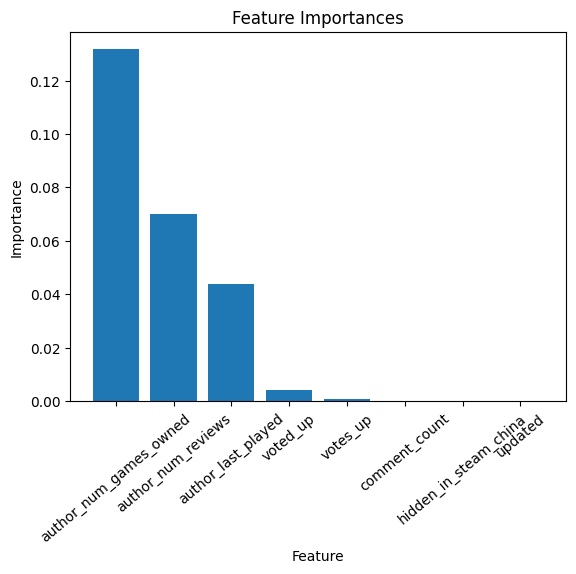

In [27]:
importances = sorted(list(zip(df.columns[:-1], map(abs, lr_model.coefficients))), key=lambda x: x[1], reverse=True)
print(importances)
values = [tup[1] for tup in importances]

x_values = list(range(len(importances)))
plt.bar(x_values, values, orientation = 'vertical')
plt.xticks(x_values, input_cols, rotation=40)

plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

In [8]:
# 0 - TN
# 1 - FN
# 2 - FP
# 3 - TP
predictions = predictions.withColumn("result", F.when((predictions["weighted_vote_score"] >= 0.8) & (predictions["prediction"] >= 0.8), 3) \
                                                .when((predictions["weighted_vote_score"] >= 0.8) & (predictions["prediction"] < 0.8), 2) \
                                                .when((predictions["weighted_vote_score"] < 0.8) & (predictions["prediction"] >= 0.8), 1) \
                                                .otherwise(0))

In [9]:
tn = predictions.filter(predictions["result"] == 0).count()
fn = predictions.filter(predictions["result"] == 1).count()
fp = predictions.filter(predictions["result"] == 2).count()
tp = predictions.filter(predictions["result"] == 3).count()

In [10]:
print(f"True negatives: {tn}\n \
False negatives: {fn}\n \
False positives: {fp}\n \
True positives: {tp}")

True negatives: 23895269
 False negatives: 11127
 False positives: 89158
 True positives: 5505


In [11]:
accuracy = (tn + tp) / (tn + fn + fp + tp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = (2 * precision * recall) / (precision + recall)

In [12]:
print(f"Accuracy: {accuracy}%\n \
Precision: {precision}%\n \
Recall: {recall}%\n \
F1-Score: {f1_score}%")

Accuracy: 0.995821642703349%
 Precision: 0.05815366088123131%
 Recall: 0.330988455988456%
 F1-Score: 0.09892627701154588%


In [18]:
lr_model.save("E:/Dataset/LR_Model")

### Random Forest

In [6]:
rf = RandomForestRegressor(labelCol='weighted_vote_score')

In [7]:
rf_model = rf.fit(train_data)

In [6]:
rf_model = RandomForestRegressionModel.load("E:/Dataset/RF_Model/")

In [7]:
predictions_rf = rf_model.transform(test_data)

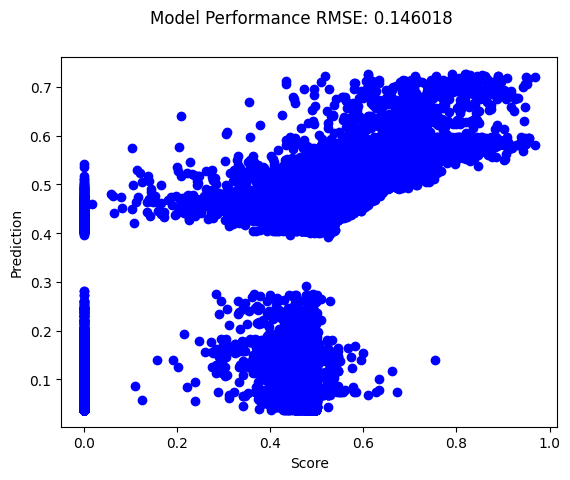

In [11]:
evaluator = RegressionEvaluator(labelCol="weighted_vote_score", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions_rf)

rfPred = rf_model.transform(final_data)
rfResult = rfPred.sample(withReplacement=False, fraction=0.001, seed=None).toPandas()

plt.plot(rfResult.weighted_vote_score, rfResult.prediction, 'bo')
plt.xlabel('Score')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

Text(0.5, 1.0, 'Feature Importances')

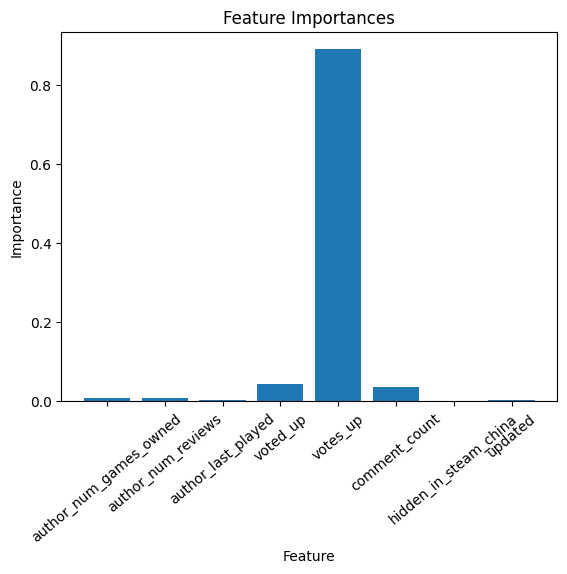

In [12]:
importances = rf_model.featureImportances

x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, input_cols, rotation=40)

plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

In [13]:
predictions_rf.show()

+-------------------+-------------------+------------------+
|           features|weighted_vote_score|        prediction|
+-------------------+-------------------+------------------+
|(8,[0,1],[1.0,1.0])|                0.0|0.1257310805674236|
|(8,[0,1],[1.0,1.0])|                0.0|0.1257310805674236|
|(8,[0,1],[1.0,1.0])|                0.0|0.1257310805674236|
|(8,[0,1],[1.0,1.0])|                0.0|0.1257310805674236|
|(8,[0,1],[1.0,1.0])|                0.0|0.1257310805674236|
|(8,[0,1],[1.0,1.0])|                0.0|0.1257310805674236|
|(8,[0,1],[1.0,1.0])|                0.0|0.1257310805674236|
|(8,[0,1],[1.0,1.0])|  0.445859879255295|0.1257310805674236|
|(8,[0,1],[1.0,1.0])|  0.476190477609634|0.1257310805674236|
|(8,[0,1],[1.0,1.0])|   0.47826087474823|0.1257310805674236|
|(8,[0,1],[1.0,2.0])|                0.0|0.1257310805674236|
|(8,[0,1],[1.0,2.0])|                0.0|0.1257310805674236|
|(8,[0,1],[1.0,2.0])|  0.431654691696167|0.1257310805674236|
|(8,[0,1],[1.0,2.0])|  0

In [11]:
# 0 - TN
# 1 - FN
# 2 - FP
# 3 - TP
predictions_rf = predictions_rf.withColumn("result", F.when((predictions_rf["weighted_vote_score"] >= 0.8) & (predictions_rf["prediction"] >= 0.8), 3) \
                                                    .when((predictions_rf["weighted_vote_score"] >= 0.8) & (predictions_rf["prediction"] < 0.8), 2) \
                                                    .when((predictions_rf["weighted_vote_score"] < 0.8) & (predictions_rf["prediction"] >= 0.8), 1) \
                                                    .otherwise(0))

In [12]:
tn = predictions_rf.filter(predictions_rf["result"] == 0).count()
fn = predictions_rf.filter(predictions_rf["result"] == 1).count()
fp = predictions_rf.filter(predictions_rf["result"] == 2).count()
tp = predictions_rf.filter(predictions_rf["result"] == 3).count()

In [13]:
print(f"True negatives: {tn}\n \
False negatives: {fn}\n \
False positives: {fp}\n \
True positives: {tp}")

True negatives: 23906396
 False negatives: 0
 False positives: 94663
 True positives: 0


In [16]:
accuracy = (tn + tp) / (tn + fn + fp + tp)
precision = tp / (tp + fp)
# recall = tp / (tp + fn)
recall = 0
# f1_score = (2 * precision * recall) / (precision + recall)

In [17]:
print(f"Accuracy: {accuracy}%\n \
Precision: {precision}%\n \
Recall: {recall}%")
# F1-Score: {f1_score}%")

NameError: name 'f1_score' is not defined

In [9]:
rf_model.save("E:/Dataset/RF_Model")

### Gradient Boosting

In [7]:
gbt = GBTRegressor(labelCol='weighted_vote_score')

In [7]:
gbt_model = gbt.fit(train_data)

In [ ]:
gbt_model = GBTRegressionModel.load("E:/Dataset/GBT_Model/")

In [ ]:
predictions_gbt = gbt_model.transform(test_data)

In [9]:
evaluator = RegressionEvaluator(labelCol="weighted_vote_score", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions_gbt)

print(rmse)

0.14241834074587653


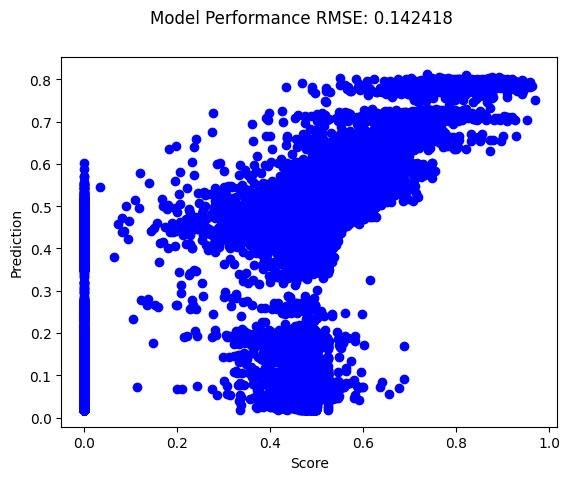

In [15]:
gbtPred = gbt_model.transform(final_data)
gbtResult = gbtPred.sample(withReplacement=False, fraction=0.001, seed=None).toPandas()

rmse = 0.14241834074587653

plt.plot(gbtResult.weighted_vote_score, gbtResult.prediction, "bo")
plt.xlabel('Score')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

Text(0.5, 1.0, 'Feature Importances')

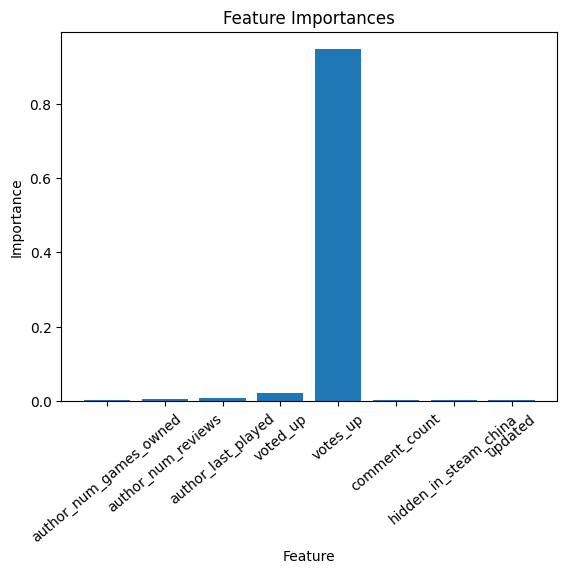

In [12]:
importances = gbt_model.featureImportances

x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, input_cols, rotation=40)

plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

In [11]:
predictions_gbt.show()

+-------------------+-------------------+-------------------+
|           features|weighted_vote_score|         prediction|
+-------------------+-------------------+-------------------+
|(8,[0,1],[1.0,1.0])|                0.0| 0.1142737908962638|
|(8,[0,1],[1.0,1.0])|                0.0| 0.1142737908962638|
|(8,[0,1],[1.0,1.0])|                0.0| 0.1142737908962638|
|(8,[0,1],[1.0,1.0])|                0.0| 0.1142737908962638|
|(8,[0,1],[1.0,1.0])|                0.0| 0.1142737908962638|
|(8,[0,1],[1.0,1.0])|                0.0| 0.1142737908962638|
|(8,[0,1],[1.0,1.0])|                0.0| 0.1142737908962638|
|(8,[0,1],[1.0,1.0])|  0.445859879255295| 0.1142737908962638|
|(8,[0,1],[1.0,1.0])|  0.476190477609634| 0.1142737908962638|
|(8,[0,1],[1.0,1.0])|   0.47826087474823| 0.1142737908962638|
|(8,[0,1],[1.0,2.0])|                0.0|0.11764903750530815|
|(8,[0,1],[1.0,2.0])|                0.0|0.11764903750530815|
|(8,[0,1],[1.0,2.0])|  0.431654691696167|0.11764903750530815|
|(8,[0,1

In [ ]:
# 0 - TN
# 1 - FN
# 2 - FP
# 3 - TP
predictions_gbt = predictions_gbt.withColumn("result", F.when((predictions_gbt["weighted_vote_score"] >= 0.8) & (predictions_gbt["prediction"] >= 0.8), 3) \
                                                        .when((predictions_gbt["weighted_vote_score"] >= 0.8) & (predictions_gbt["prediction"] < 0.8), 2) \
                                                        .when((predictions_gbt["weighted_vote_score"] < 0.8) & (predictions_gbt["prediction"] >= 0.8), 1) \
                                                        .otherwise(0))

In [ ]:
tn = predictions_gbt.filter(predictions_gbt["result"] == 0).count()
fn = predictions_gbt.filter(predictions_gbt["result"] == 1).count()
fp = predictions_gbt.filter(predictions_gbt["result"] == 2).count()
tp = predictions_gbt.filter(predictions_gbt["result"] == 3).count()

In [ ]:
print(f"True negatives: {tn}\n \
False negatives: {fn}\n \
False positives: {fp}\n \
True positives: {tp}")

True negatives: 23895269
 False negatives: 11127
 False positives: 89158
 True positives: 5505


In [ ]:
accuracy = (tn + tp) / (tn + fn + fp + tp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = (2 * precision * recall) / (precision + recall)

In [ ]:
print(f"Accuracy: {accuracy}%\n \
Precision: {precision}%\n \
Recall: {recall}%\n \
F1-Score: {f1_score}%")

Accuracy: 0.995821642703349%
 Precision: 0.05815366088123131%
 Recall: 0.330988455988456%
 F1-Score: 0.09892627701154588%


In [10]:
gbt_model.save("E:/Dataset/GBT_Model")